In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sys

#https://towardsdatascience.com/ml-from-scratch-linear-polynomial-and-regularized-regression-models-725672336076

#za prikaz podataka
import matplotlib.pyplot as plt
import seaborn as sns

from random import seed
from random import randrange

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
def remove_outlayers_hc(df):
    for index, row in df.iterrows():
        if  row['godina_iskustva'] >= 53:
            df.drop(index, inplace=True)
        elif  row['plata'] > 200000:
            df.drop(index, inplace=True)
        elif row['zvanje'] != 'Prof' and row['plata'] > 120000:
            df.drop(index, inplace=True)
            
def preprocess_data(df):
    
    remove_outlayers_hc(df)
    df = df.reset_index(drop=True)

    
    #PRAVLJENJE DUMMIES KLASA ZA ONE HOT ENCODING
    zvanje_dummy = pd.get_dummies(df.zvanje)
    oblast_dummy = pd.get_dummies(df.oblast)
    godina_doktor_dummy = pd.get_dummies(df.godina_doktor)
    godina_iskustva_dummy = pd.get_dummies(df.godina_iskustva)
    pol_dummy = pd.get_dummies(df.pol)
    plata_dummy = pd.get_dummies(df.plata)
    
    
    #SVE MERGOVANO TREBA DA SE IZBACI NEPOTREBNO DA SE IZBJEGNE DUMMY TRAP
    merged = pd.concat([df,zvanje_dummy, oblast_dummy, godina_doktor_dummy, godina_iskustva_dummy,
                       pol_dummy, plata_dummy],axis='columns')
    
    
    #PRAVLJENJE DUMMY DATA FRAMOVA I IZBACIVANJE PO JEDNE KOLONE IZ SVAKOG KAKO
    #BI SE IZBEGAO DUMMY TRAP
    zvanje_dummy = pd.get_dummies(df.zvanje)
    zvanje_dummy_dropped_one = zvanje_dummy.drop(['AsstProf'], axis='columns')
    zvanje_dummy_dropped_one.columns = ['zvanje_Prof', 'zvanje_AssocProf']

    oblast_dummy = pd.get_dummies(df.oblast)
    oblast_dummy_dropped_one = oblast_dummy.drop(['A'], axis='columns')
    oblast_dummy_dropped_one.columns = ['oblast_B']

#     pol_dummy = pd.get_dummies(df.pol)
#     pol_dummy_dropped_one = pol_dummy.drop(['Male'], axis='columns')
#     pol_dummy_dropped_one.columns = ['pol_Female']

                                          
    #MERGOVANJE DUMMY DATA FRAMOVA SA PODACIMA
    merged = pd.concat([df,zvanje_dummy_dropped_one,oblast_dummy_dropped_one], axis = 'columns') #,pol_dummy_dropped_one

    #IZBACIVANJE KOLONA OD KOJE SU IZVEDENE DUMMY DATA FRAMOVI
    final_df = merged.drop(['zvanje','oblast','pol'], axis='columns')
                                          
    return final_df

In [3]:
# Splituje podatke na test i train odmerom split=0.7 ako se ne navede drugacije
def train_test_split_random(dataset, data_size,split=0.7):
    
    train_size_counter = 0
    indices = []
    train = pd.DataFrame()
    train_size = split * data_size
    dataframe_copy = dataset
    while train_size_counter < train_size:
        train_size_counter = train_size_counter + 1
        index = randrange(data_size)
        
        while(check_if_element_in_list(index, indices)):
            index = randrange(data_size)
                 
        indices.append(index)
    
    for i in range(len(indices)+1):
        train = train.append(dataframe_copy.iloc[[i]])
        
    dataframe_copy = dataframe_copy.drop(labels = indices, axis=0)
    dataframe_copy = dataframe_copy.reset_index(drop=True)
        
    return train, dataframe_copy

def check_if_element_in_list(x, lista):
    if x in lista:
        return True
    else:
        return False

In [4]:
#Racunanje RMSE
def RMSE(n,predicted, acctual):
    suma = 0
    for i in range(0, n):
        suma += (predicted[i] - acctual.iloc[i])**2
    return np.sqrt(suma/n)


def mse(y_actual, y_predicted):
    n = len(y_actual)
    s = 0.0
    for i in range(n):
        s += (y_predicted[i] - y_actual[i]) ** 2
    loss = s / n
    return loss


def rmse(y_actual, y_predicted):
    return np.sqrt(mse(y_actual, y_predicted))

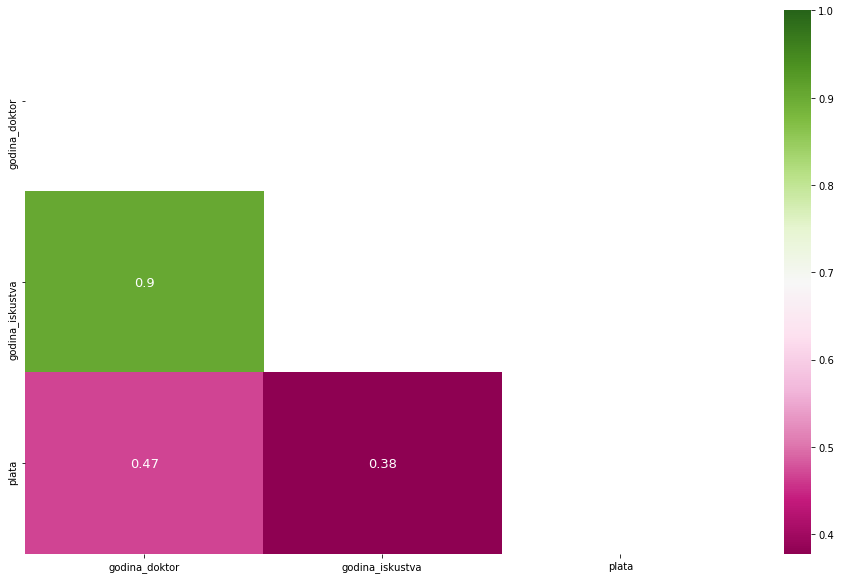

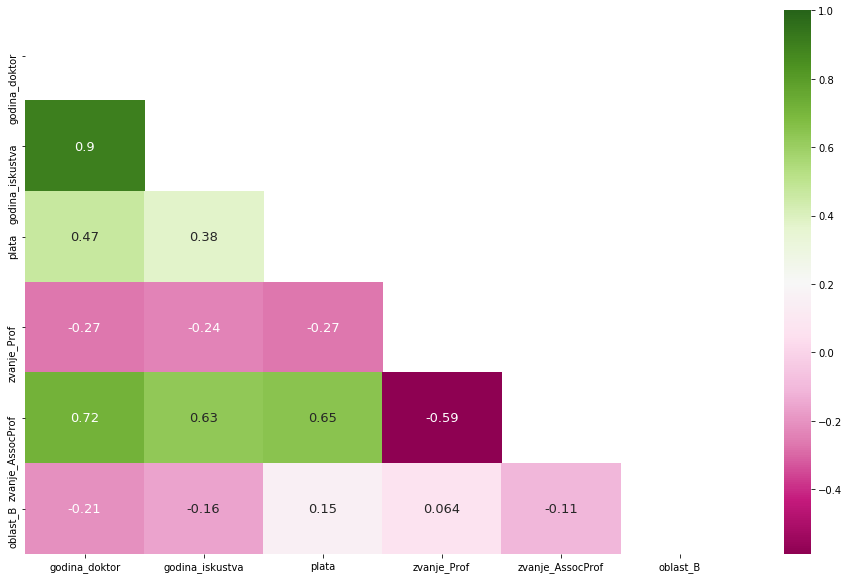

In [5]:
train = pd.read_csv('train.csv')
final_df = preprocess_data(train)

# #Izbacivanje kategorijskih podatak iz dataframe za prikazivanje korelacije
heatmap_view = final_df.drop(['zvanje_Prof','zvanje_AssocProf','oblast_B'], axis='columns') #,'pol_Female'

#ISCRTAVANJE HEAT MAPE RADI ANALIZE PODATAKA
corr = heatmap_view.corr()
mask = np.zeros_like(heatmap_view.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(16,10))
sns.heatmap(heatmap_view.corr(),cmap="PiYG", mask=mask, annot=True, annot_kws={"size" : 13})

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()



#ISCRTAVANJE HEAT MAPE BEZ UKLANJANJA KATEGORIJSKIH PODATAKA RADI ANALIZE PODATAKA
corr = final_df.corr()

mask = np.zeros_like(final_df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(16,10))
sns.heatmap(final_df.corr(),cmap="PiYG", mask=mask, annot=True, annot_kws={"size" : 13})

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

,godina_doktor,godina_iskustva,plata
count,297.000000,297.000000,297.000000
mean,21.936027,17.178451,113749.393939
std,12.836785,13.005657,29966.582826
min,1.000000,0.000000,57800.000000
25%,11.000000,6.000000,91300.000000
50%,21.000000,16.000000,107309.000000
75%,32.000000,26.000000,133700.000000
max,56.000000,60.000000,231545.000000


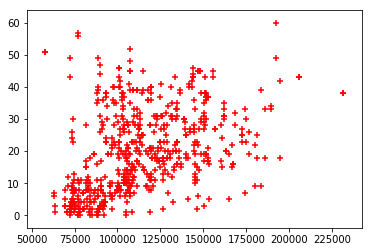

In [6]:
#ISCRTAVANJE JEDNOG PO JEDNOG PLOTA DA SE VIDI DA LI IMA OUTLIERA
%matplotlib inline
df = pd.read_csv('train.csv')


#Plotovanje vrednosti jednih sa drugim

#plt.xlabel('Plata')
#plt.ylabel('')

#plt.scatter(df.plata, df.zvanje, color='red', marker='+')
#plt.scatter(df.plata, df.oblast, color='red', marker='+')
#plt.scatter(df.plata, df.pol, color='red', marker='+')

plt.scatter(df.plata, df.godina_doktor, color='red', marker='+')
plt.scatter(df.plata, df.godina_iskustva, color='red', marker='+')


#Boxplot da se vide outlieri
# df.plot(kind='box')
# plt.show()

df.describe()

In [67]:
class ElasticNetRegression(object):
    """
    Useful resources:
    * https://statweb.stanford.edu/~jhf/ftp/glmnet.pdf
    * https://xavierbourretsicotte.github.io/
    """
    def __init__(self, learning_rate=0.01, rho_value=0.1, n_iterations=2000, weights=None):
        self.n_iterations = n_iterations
        self.weights = weights
        self.learning_rate = learning_rate
        self.rho_value = rho_value

    def preprocess_coordinate_descent(self, x):
        m, n = x.shape  # m - number of examples, n - number of features
        l2_regularization_parameter = m * self.learning_rate * (1.0 - self.rho_value)
        l1_regularization_parameter = m * self.learning_rate * self.rho_value
        self.weights = np.zeros(n)
        # Return an array (ndim >= 1) laid out in Fortran order in memory, for a little bit of a faster computing.
        x = np.asfortranarray(x)
        return x, l1_regularization_parameter, l2_regularization_parameter

    def fit(self, x, y):
        # minimize (1/2) * norm(y - X w, 2)^2 + l1_reg ||w||_21 + (1/2) * l2_reg norm(w, 2)^2
        # (1 / (2 * n_samples)) * ||Y - XW||^2_Fro + alpha * ||W||_21
        #  ||W||_21 = \\sum_i \\sqrt{\\sum_j w_{ij}^2}
        init_step = True
        x, l1, l2 = self.preprocess_coordinate_descent(x)
        xy_dot = np.dot(x.T, y)
        n = x.shape[1]  # number of features
        feature_set = set(range(n))
        feature_correlations = np.zeros(shape=(n, n))
        get_norm = np.sum(x**2, axis=0)

        # initialize gradients
        grads = np.zeros(n)

        for i in range(self.n_iterations):
            for j in feature_set:
                weights = self.weights[j]
                if init_step:
                    feature_correlations[:, j] = np.dot(x[:, j], x)
                    grads[j] = xy_dot[j] - np.dot(feature_correlations[:, j], self.weights)

                self.weights[j] = self.thresholding(grads[j] + weights * get_norm[j]) * max(
                    abs(grads[j] + weights * get_norm[j]) - l2, 0) / (get_norm[j] + l1)

                # Update gradients if there is a change in weights
                if weights != self.weights[j]:
                    for k in feature_set:
                        if self.n_iterations >= 1 or k <= j:
                            grads[k] -= feature_correlations[j, k] * (self.weights[j] - weights)

            init_step = False

            feature_set_copy = set.copy(feature_set)
            for f in feature_set_copy:
                if self.weights[f] == 0:
                    feature_set.remove(f)

    def predict(self, x):
        return x @ self.weights.T

    def thresholding(self, value):
        if value == 0:
            return 0
        elif value > 0:
            return 1.0
        else:
            return -1.0

In [89]:
df_main = pd.read_csv("train.csv")
df_size = df_main[df_main.columns[0]].count() -1

[df_train, df_test] = train_test_split_random(df_main, df_size, split=0.8)

final_df_train = preprocess_data(df_train)
final_df_test = preprocess_data(df_test)

Y_train = final_df_train['plata']
X_train = final_df_train[[i for i in list(final_df_train.columns) if i != 'plata']]

Y_test = final_df_test['plata']
X_test = final_df_test[[i for i in list(final_df_test.columns) if i != 'plata']]


# ss = StandardScaler()
# ss.fit(Y_train)
# Y_train_scaled = ss.transform(Y_train)
# #ss.inverse_transform(Y_train_scaled)

# ss.fit(Y_test)
# Y_test_scaled = ss.transform(Y_train)
##ss.inverse_transform(Y_test_scaled)

#ELASTIC REGRESION
elastic_net_model = ElasticNetRegression(rho_value=0.03) #0.03  # bigger means more Ridge factor
elastic_net_model.fit(X_train, Y_train)
y_pred = elastic_net_model.predict(X_test)


#LASO NE RADI
# model = LassoRegression( iterations = 1000, learning_rate = 0.01, l1_penality = 500 )
# model.fit(X_train, Y_train)
# y_pred = model.predict( X_test )


#(n_iter, learning_rate, alpha)
# model = Lasso(1000, 1e-2, 1.0)
# model.fit(X_train, Y_train)
# y_pred = model.predict( X_test )


# #Ovaj radi mozda najbolje
# model = Multiple_Linear_Regression()
# model.fit(X_train, Y_train)
# y_pred = model.predict(X_test)



rmserr = rmse( Y_test, y_pred)
# rmserr = RMSE(Y_test.size, Y_test, y_pred)
#rmserr = rmse( Y_test, y_pred)
print(rmserr) 

29427.277069368545


In [ ]:
df_main = pd.read_csv("train.csv")
remove_outlayers_hc(df_main)
df_test[df_test.columns[0]].count() -1

In [ ]:
df_main.iloc[:, :-1].values

In [70]:
import numpy as np

class StandardScaler:

    def fit(self, X):

        self.mean_ = np.mean(X, axis=0)
        self.var_ = np.var(X, axis=0)


    def transform(self, X):
        X_std = (X - self.mean_) / np.sqrt(self.var_)

        return X_std

    def inverse_transform(self, X_std):
        X = X_std * np.sqrt(self.var_) + self.mean_

        return X
    

In [ ]:
df_main = pd.read_csv("train.csv")
df_size = df_main[df_main.columns[0]].count() -1

[df_train, df_test] = train_test_split_random(df_main, df_size, split=0.8)

final_df_train = preprocess_data(df_train)
final_df_test = preprocess_data(df_test)


Y_train = final_df_train['plata']
X_train = final_df_train[[i for i in list(final_df_train.columns) if i != 'plata']]

Y_test = final_df_test['plata']
X_test = final_df_test[[i for i in list(final_df_test.columns) if i != 'plata']]

In [ ]:
ss = StandardScaler()
ss.fit(Y_train)
a = ss.transform(Y_train)
ss.inverse_transform(a)

In [85]:
import numpy as np
import pandas as pd

from random import randrange


def preprocess_data(df):

    #remove_outlayers_hc(df)
    df = df.reset_index(drop=True)


    #PRAVLJENJE DUMMIES KLASA ZA ONE HOT ENCODING
    zvanje_dummy = pd.get_dummies(df.zvanje)
    oblast_dummy = pd.get_dummies(df.oblast)
    godina_doktor_dummy = pd.get_dummies(df.godina_doktor)
    godina_iskustva_dummy = pd.get_dummies(df.godina_iskustva)
    pol_dummy = pd.get_dummies(df.pol)
    plata_dummy = pd.get_dummies(df.plata)


    #SVE MERGOVANO TREBA DA SE IZBACI NEPOTREBNO DA SE IZBJEGNE DUMMY TRAP
    merged = pd.concat([df,zvanje_dummy, oblast_dummy, godina_doktor_dummy, godina_iskustva_dummy,
                        pol_dummy, plata_dummy],axis='columns')


    #PRAVLJENJE DUMMY DATA FRAMOVA I IZBACIVANJE PO JEDNE KOLONE IZ SVAKOG KAKO
    #BI SE IZBEGAO DUMMY TRAP
    zvanje_dummy = pd.get_dummies(df.zvanje)
    zvanje_dummy_dropped_one = zvanje_dummy.drop(['AsstProf'], axis='columns')
    zvanje_dummy_dropped_one.columns = ['zvanje_Prof', 'zvanje_AssocProf']

    oblast_dummy = pd.get_dummies(df.oblast)
    oblast_dummy_dropped_one = oblast_dummy.drop(['A'], axis='columns')
    oblast_dummy_dropped_one.columns = ['oblast_B']

    #     pol_dummy = pd.get_dummies(df.pol)
    #     pol_dummy_dropped_one = pol_dummy.drop(['Male'], axis='columns')
    #     pol_dummy_dropped_one.columns = ['pol_Female']


    #MERGOVANJE DUMMY DATA FRAMOVA SA PODACIMA
    merged = pd.concat([df,zvanje_dummy_dropped_one,oblast_dummy_dropped_one], axis = 'columns') #,pol_dummy_dropped_one

    #IZBACIVANJE KOLONA OD KOJE SU IZVEDENE DUMMY DATA FRAMOVI
    final_df = merged.drop(['zvanje','oblast','pol'], axis='columns')

    return final_df

# Splituje podatke na test i train odmerom split=0.7 ako se ne navede drugacije
def train_test_split_random(dataset, data_size,split=0.7):

    train_size_counter = 0
    indices = []
    train = pd.DataFrame()
    train_size = split * data_size
    dataframe_copy = dataset
    while train_size_counter < train_size:
        train_size_counter = train_size_counter + 1
        index = randrange(data_size)

        while(check_if_element_in_list(index, indices)):
            index = randrange(data_size)

        indices.append(index)

    for i in range(len(indices)+1):
        train = train.append(dataframe_copy.iloc[[i]])

    dataframe_copy = dataframe_copy.drop(labels = indices, axis=0)
    dataframe_copy = dataframe_copy.reset_index(drop=True)

    return train, dataframe_copy

def check_if_element_in_list(x, lista):
    if x in lista:
        return True
    else:
        return False

#Racunanje RMSE
def RMSE(n,predicted, acctual):
    suma = 0
    for i in range(0, n):
        suma += (predicted[i] - acctual.iloc[i])**2
    return np.sqrt(suma/n)

def mse(y_actual, y_predicted):
    n = len(y_actual)
    s = 0.0
    for i in range(n):
        s += (y_predicted[i] - y_actual[i]) ** 2
    loss = s / n
    return loss

def rmse(y_actual, y_predicted):
    return np.sqrt(mse(y_actual, y_predicted))

# Ridge Regression
class RidgeRegression() :

    def __init__( self, learning_rate, iterations, l2_penality ) :

        self.learning_rate = learning_rate
        self.iterations = iterations
        self.l2_penality = l2_penality

    # Function for model training
    def fit( self, X, Y ) :

        # no_of_training_examples, no_of_features
        self.m, self.n = X.shape

        # weight initialization
        self.W = np.zeros( self.n )

        self.b = 0
        self.X = X
        self.Y = Y

        # gradient descent learning

        for i in range( self.iterations ) :
            self.update_weights()
        return self

    # Helper function to update weights in gradient descent

    def update_weights( self ) :
        Y_pred = self.predict( self.X )

        # calculate gradients
        dW = ( - ( 2 * ( self.X.T ).dot( self.Y - Y_pred ) ) +
               ( 2 * self.l2_penality * self.W ) ) / self.m
        db = - 2 * np.sum( self.Y - Y_pred ) / self.m

        # update weights
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
        return self

    # Hypothetical function  h( x )
    def predict( self, X ) :
        return X.dot( self.W ) + self.b

# Driver code
df_main = pd.read_csv("train.csv")
df_size = df_main[df_main.columns[0]].count() -1

[df_train, df_test] = train_test_split_random(df_main, df_size, split=0.8)

final_df_train = preprocess_data(df_train)
final_df_test = preprocess_data(df_test)


Y_train = final_df_train['plata']
#X_train = final_df_train['godina_doktor']
#X_train = final_df_train['godina_iskustva']
X_train = final_df_train[[i for i in list(final_df_train.columns) if i != 'plata']]

Y_test = final_df_test['plata']
#X_test = final_df_test['godina_doktor']
#X_test = final_df_test['godina_iskustva']
X_test = final_df_test[[i for i in list(final_df_test.columns) if i != 'plata']]


model = RidgeRegression( iterations = 1000,
                             learning_rate = 0.01, l2_penality = 1 )
model.fit( X_train, Y_train )

# Prediction on test set
Y_pred = model.predict( X_test )


#rmserr = RMSE(Y_test.size, Y_test, y_pred)
rmserr = rmse( Y_test, Y_pred)
print(rmserr)

nan
